<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/05.%20Sarria-Sant%20Gervasi/Forecasting_(Indicador_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**




**Forecasting** es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variaedad de constextos, como en finanzas, meteorologia, ventas entre otros

Se realizaran comprobaciones de cointegracion, estacionariedad, para determinar que modelo aplicar entre los seleccionados:

* Modelos VAR (Vector Autoregressive)
* Modelos VARMA (Vector Autoregressive Moving Average)
* Modelos VARMAx (VARMA con Variables Exógenas)
*	Modelos VECM (Vector Error Correlation Model)

##Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [2]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Estudios_Obligatorios,ConsumResidencial,Pm25,Pm10,Participacion,AñosEspVida,Internet,Movil,Index_Turisme,m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2


In [3]:
print(data.dtypes)

Any                        int64
Trimestre                  int64
Mes                        int64
Codi_Districte             int64
Nom_Districte             object
Codi_Barri                 int64
Nom_Barri                 object
Compraventa_Unitario     float64
ParadosReg                 int64
Estudios_Obligatorios    float64
ConsumResidencial        float64
Pm25                     float64
Pm10                     float64
Participacion            float64
AñosEspVida              float64
Internet                 float64
Movil                    float64
Index_Turisme            float64
m² por habitante         float64
dtype: object


## Analisis por grupo de indicadores (Paro)

### Preparacion de datos

In [4]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','ParadosReg']]

In [5]:
df_paro = df_sel.dropna()

In [6]:
df_paro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8541 entries, 0 to 8540
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Any                   8541 non-null   int64  
 1   Trimestre             8541 non-null   int64  
 2   Mes                   8541 non-null   int64  
 3   Codi_Districte        8541 non-null   int64  
 4   Nom_Districte         8541 non-null   object 
 5   Codi_Barri            8541 non-null   int64  
 6   Nom_Barri             8541 non-null   object 
 7   Compraventa_Unitario  8541 non-null   float64
 8   ParadosReg            8541 non-null   int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 600.7+ KB


In [7]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_paro['Fecha'] = pd.to_datetime(df_paro['Any'].astype(str) + '-' + df_paro['Mes'].astype(str) + '-1')

In [8]:
# Modificamos el indice del dataset por la fecha
df_paroI = df_paro.set_index('Fecha')

In [9]:
df_paroI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg
Fecha,,,,,,,,,
2014-01-01,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588
2014-02-01,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539
2014-03-01,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572
2014-04-01,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510
2014-05-01,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379


### Analisis Exploratorio

Filtramos los datos por el distrito de Sarria-Sant Gervasi -> Codi_Districte = 5

In [10]:
df_paroFiltrado = df_paroI[df_paroI['Codi_Districte'] == 5]

In [11]:
# Agrupamos los datos
df_paroBarna =df_paroFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [12]:
df_paroBarna.head()

,Compraventa_Unitario,ParadosReg
Fecha,,
2014-01-01,4198.150000,879.000000
2014-02-01,4198.150000,864.500000
2014-03-01,4198.150000,853.166667
2014-04-01,4246.083333,844.500000
2014-05-01,4246.083333,811.833333


In [13]:
df_paroBarna.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 117 entries, 2014-01-01 to 2023-09-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Compraventa_Unitario  117 non-null    float64
 1   ParadosReg            117 non-null    float64
dtypes: float64(2)
memory usage: 2.7 KB


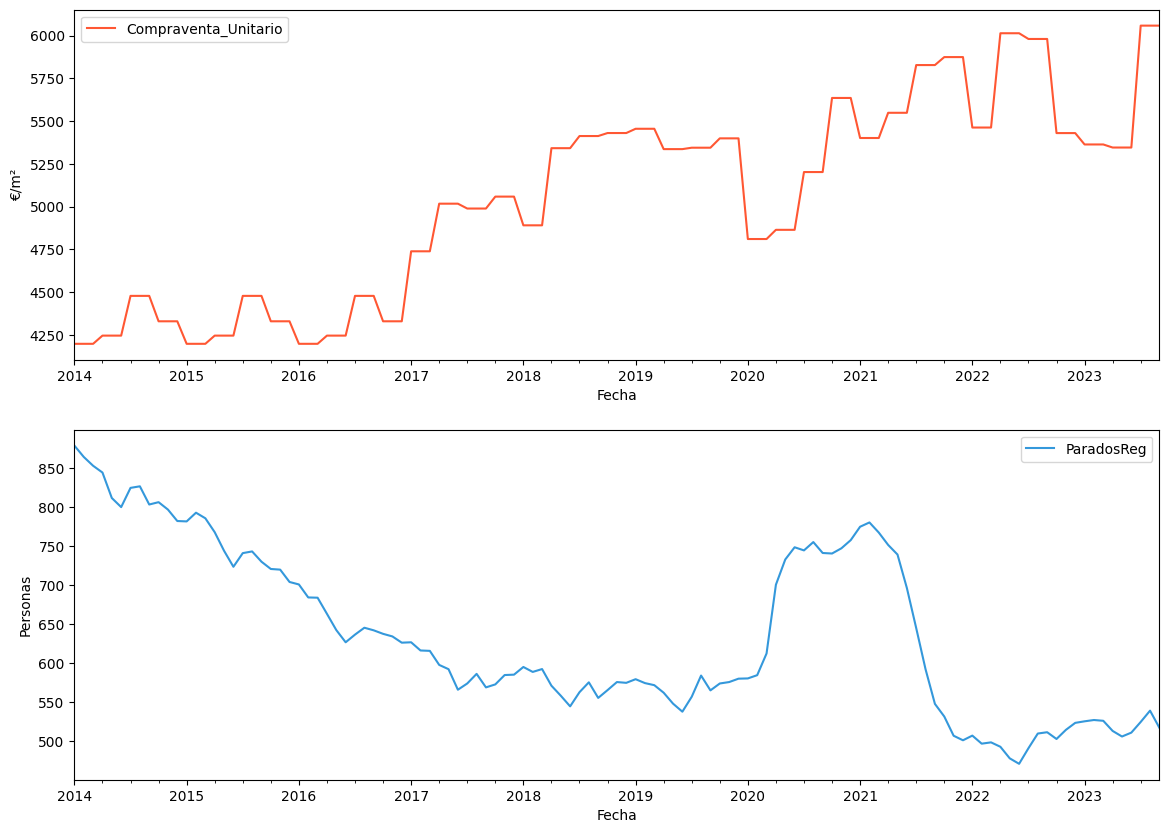

In [14]:
fig, axes = plt.subplots(nrows = int(len(df_paroBarna.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²', 'Personas']
colores = ['#FF5733', '#3498DB']

for i, (col,ax) in enumerate(zip(df_paroBarna.columns, axes.flatten())):
    df_paroBarna[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Cada una de las series tiene patrones de tendencia muy diferentes entre si

In [15]:
corr=df_paroBarna.corr()
corr

,Compraventa_Unitario,ParadosReg
Compraventa_Unitario,1.000000,-0.669068
ParadosReg,-0.669068,1.000000


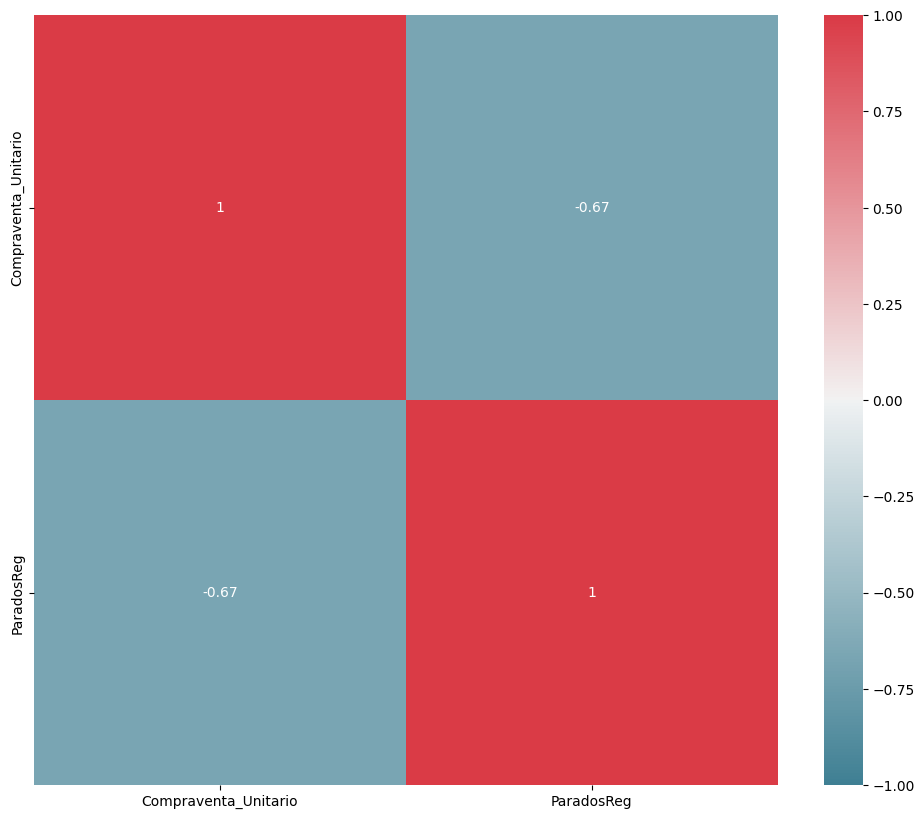

In [16]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

Tambien podemos observar como las 2 variables tienen una alta correlacion inversa

### Dividir los datos en conjunto de Entrenamiento y Prueba

In [17]:
fecha_division = '2023-01-01'

X_train, X_test = df_paroBarna[df_paroBarna.index<fecha_division], df_paroBarna[df_paroBarna.index>=fecha_division]
print(X_train.shape, X_test.shape)

(108, 2) (9, 2)


Los modelos siguientes se ajustarán al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.

###Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no sobre los datos originales

In [18]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [19]:
cointegration_test(X_train[['Compraventa_Unitario', 'ParadosReg']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  4.37      > 12.3212   =>   False
ParadosReg >  0.11      > 4.1296    =>   False


- **Compraventa_Unitario:** No hay suficiente evidencia estadística para rechazar la hipótesis nula de no cointegración. Esto sugiere que "Compraventa_Unitario" no tiene una relación de equilibrio estacionario de largo plazo con las otras series en el sistema.
- **ParadosReg:** Similarmente, "ParadosReg" tampoco muestra evidencia de cointegración. No existe una combinación lineal estacionaria que vincule esta serie con otras en el sistema a largo plazo.

Para un análisis conjunto que aún considera las interacciones entre múltiples series no cointegradas, usaremos un modelo VAR (Vector Autoregressive) o VARMA (Vector Autoregressive Moving Average) y descartaremos el modelo VECM (Vector Error Correlation Model), pero primero transformaremos comprobaremos y transformaremos por diferenciacion las veces necesrarias para convertir las series en estacionarias

### Prueba de estacionariedad


Un requisito indispensable para poder aplicar los modelo, es que los datos sean estacionarios.  Para comprobarlo realizaremos el Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [20]:
import statsmodels.tsa.stattools as sts

In [21]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.820608
Serie de tiempo ParadosReg
p-value: 0.062923


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [22]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,ParadosReg
Fecha,,
2014-02-01,0.000000,-14.500000
2014-03-01,0.000000,-11.333333
2014-04-01,47.933333,-8.666667
2014-05-01,0.000000,-32.666667
2014-06-01,0.000000,-11.666667


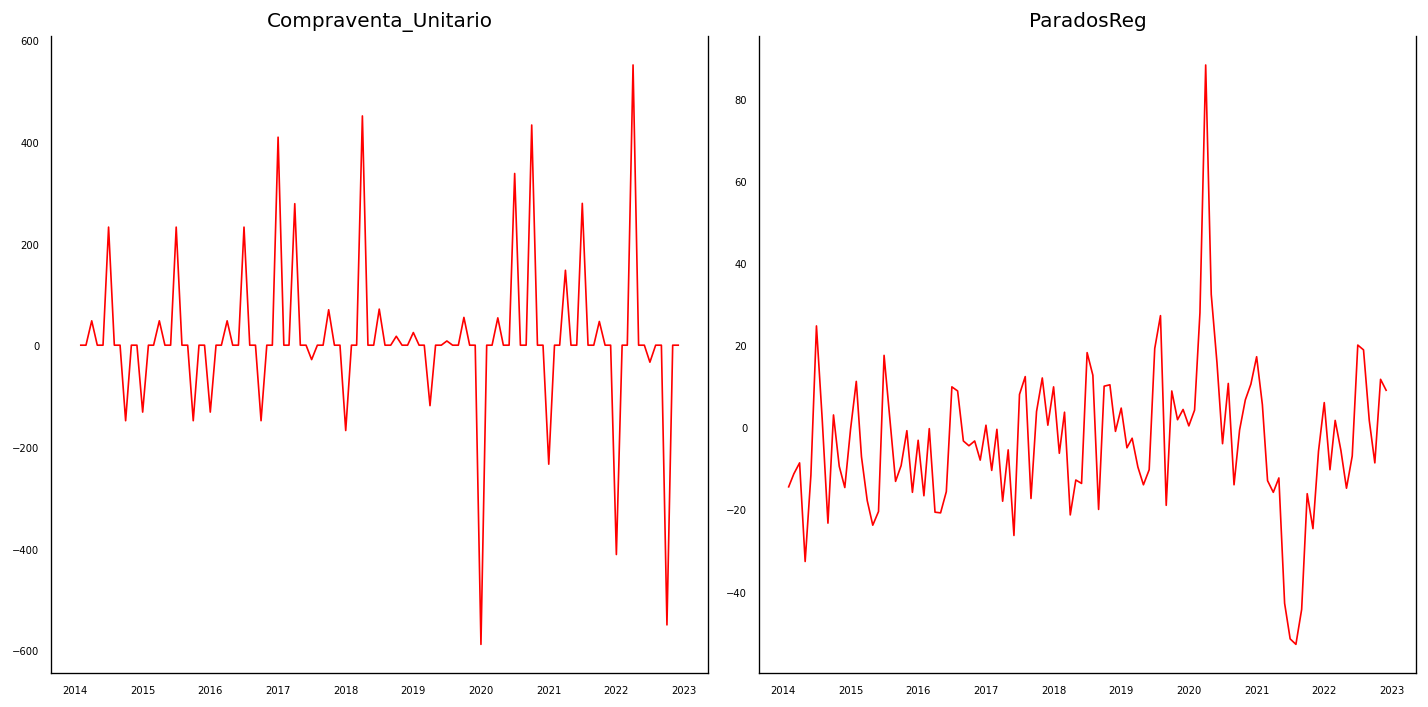

In [23]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [24]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable ParadosReg
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 1 orden de diferenciación se obtienen series estacionarias.

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola srie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de usus propios valores pasados y de los valores pasados de las otras series temporales.

#### Seleccionando el orden del modelo

In [25]:
from statsmodels.tsa.api import VAR

In [26]:
model = VAR(X_train_transformed)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [28]:
modelsel=model.select_order(25)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,16.11,16.17,9.896e+06,16.13
1,15.87*,16.05*,7.797e+06*,15.94*
2,15.93,16.22,8.278e+06,16.05
3,15.99,16.40,8.766e+06,16.15
4,16.03,16.56,9.192e+06,16.24
5,16.10,16.75,9.867e+06,16.36
6,16.01,16.77,9.000e+06,16.31
7,16.09,16.97,9.837e+06,16.45
8,16.12,17.11,1.010e+07,16.52
9,16.17,17.29,1.076e+07,16.62


El orden óptimo parece ser el modelo VAR(1), ya que tiene los valores más bajos en los criterios AIC, BIC y FPE, y uno de los valores más bajos en HQIC.

#### Ajustando el modelo

In [29]:
res = model.fit(maxlags=1)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 16, May, 2024
Time:                     16:51:16
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    15.7812
Nobs:                     106.000    HQIC:                   15.6915
Log likelihood:          -1123.23    FPE:                6.14082e+06
AIC:                      15.6304    Det(Omega_mle):     5.80744e+06
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                           9.742385        14.914565            0.653           0.514
L1.Compraventa_Unitario        -0.010212         0.098454           -0.104           0.917
L1.Pa

La correlación entre los residuos de "Compraventa_Unitario" y "ParadosReg" es de -0.030081, lo que indica una relación muy débil y prácticamente nula entre las discrepancias de estos dos indicadores. Esto sugiere que los errores en la predicción de "Compraventa_Unitario" son prácticamente independientes de los errores en la predicción de "ParadosReg".


In [30]:
res.is_stable()

True

In [31]:
X_train.columns

Index(['Compraventa_Unitario', 'ParadosReg'], dtype='object')

###### Causalidad de Granger

In [32]:
grangercaus=res.test_causality(['ParadosReg'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.4990,3.887,0.481,"(1, 206)"


In [33]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['ParadosReg'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.5123,3.887,0.475,"(1, 206)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede causar la otra serie temporal

Estos resultados indican que, dentro del marco temporal y los datos analizados, las variaciones en "Compraventa_Unitario" no proporcionan información predictiva significativa sobre las variaciones en "ParadosReg".

###### Matriz de causalidad de Granger


In [34]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=1
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

,Compraventa_Unitario_x,ParadosReg_x
Compraventa_Unitario_y,1.0000,0.4678
ParadosReg_y,0.4736,1.0000


Estos resultados indican que ambas variables tienen una relación de retroalimentación entre sí, donde tanto las compraventas unitarias como el desempleo registrado influyen en el otro en cierta medida.

#### Diagnosis del modelo


###### Residuos

In [35]:
residuals=res.resid

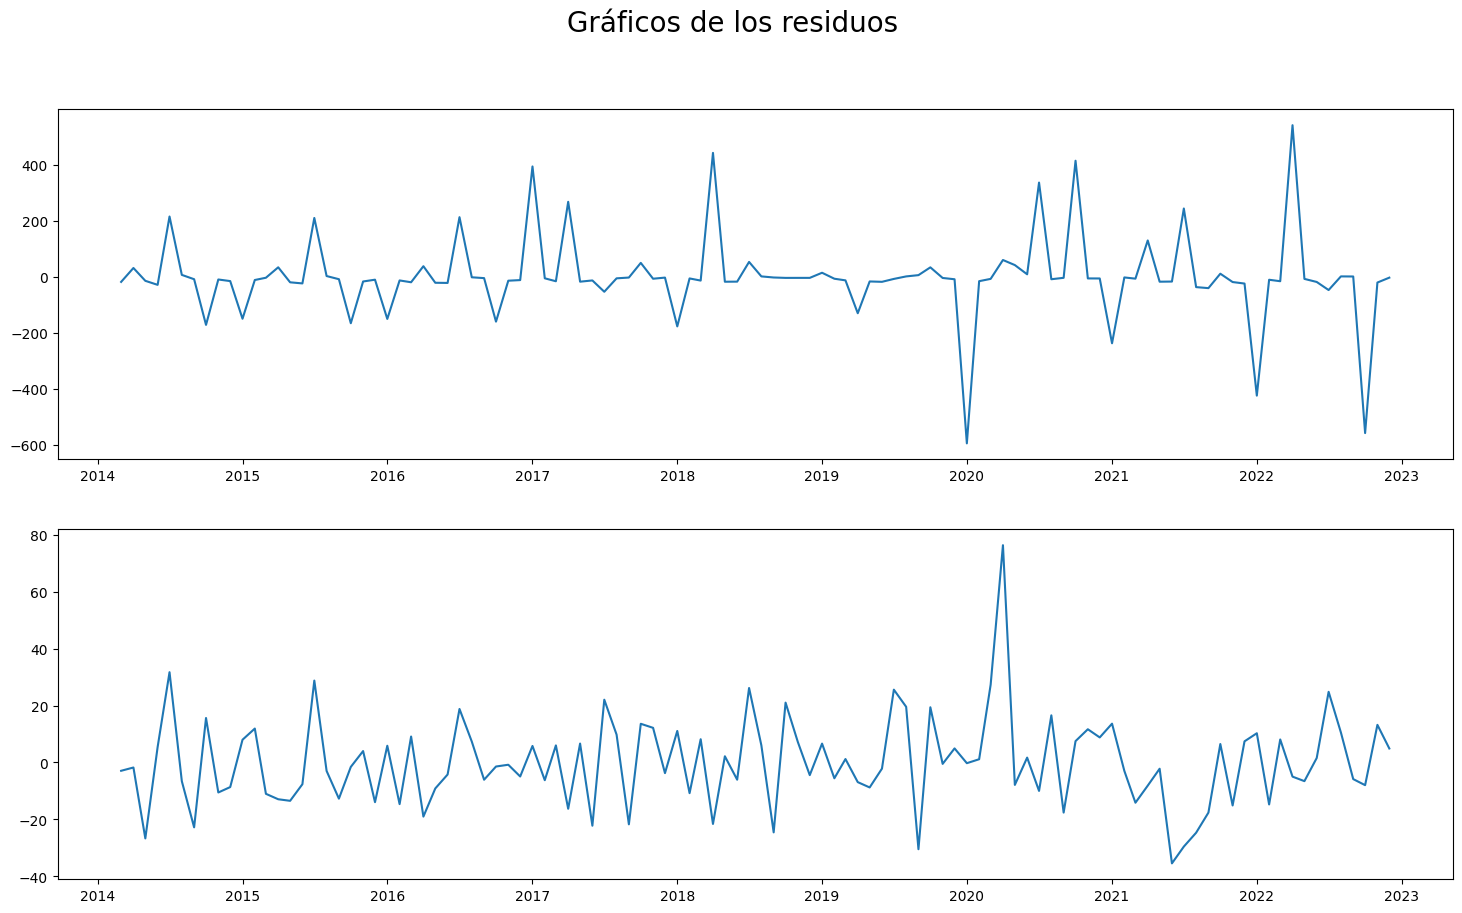

In [36]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [37]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[7.170061361685357e-08, 5.158092350589873e-18]

Todos los p-valores son < 0.1 por tanto se rechaza la hipótesis nula de que las 2 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias.



###### ACF de los Residuos


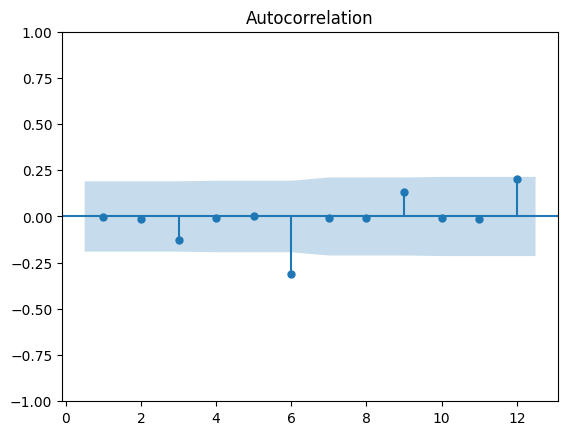

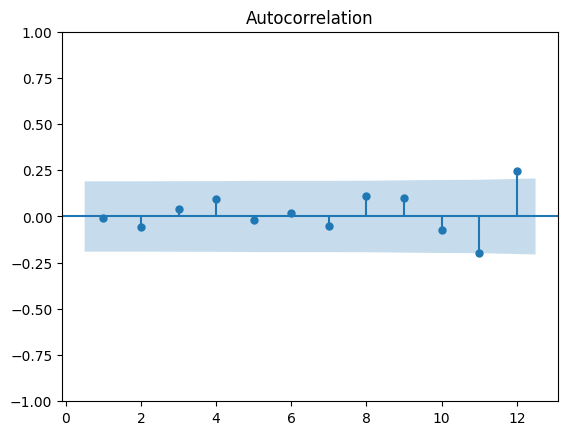

In [38]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Se observa que casi todos los puntos están dentro del intervalo de confianza hasta el rezago 11, lo que sugiere que no hay autocorrelaciones significativas para esos rezagos. Esto es un buen indicio y sugiere que el modelo está adecuadamente especificado para estos rezagos.

El punto en el rezago 12 que sale del intervalo de confianza indica una autocorrelación significativa. Este es un hallazgo importante que puede sugerir varias cosas:
- Subespecificación del Modelo: Es posible que el modelo necesite más rezagos para capturar adecuadamente la dinámica subyacente de las series temporales, especialmente si hay una periodicidad o estacionalidad no capturada por el modelo actual.
- Estructura Estacional: Si el modelo no incluyó términos para manejar la estacionalidad y los datos son estacionales (como datos mensuales con patrones anuales), esto podría explicar por qué se detecta autocorrelación a este rezago.



In [39]:
res = model.fit(12)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 16, May, 2024
Time:                     16:57:02
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    17.3179
Nobs:                     95.0000    HQIC:                   16.5169
Log likelihood:          -978.350    FPE:                8.87803e+06
AIC:                      15.9737    Det(Omega_mle):     5.56418e+06
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           24.981477        18.772280            1.331           0.183
L1.Compraventa_Unitario         -0.025120         0.118121           -0.213           0.832
L

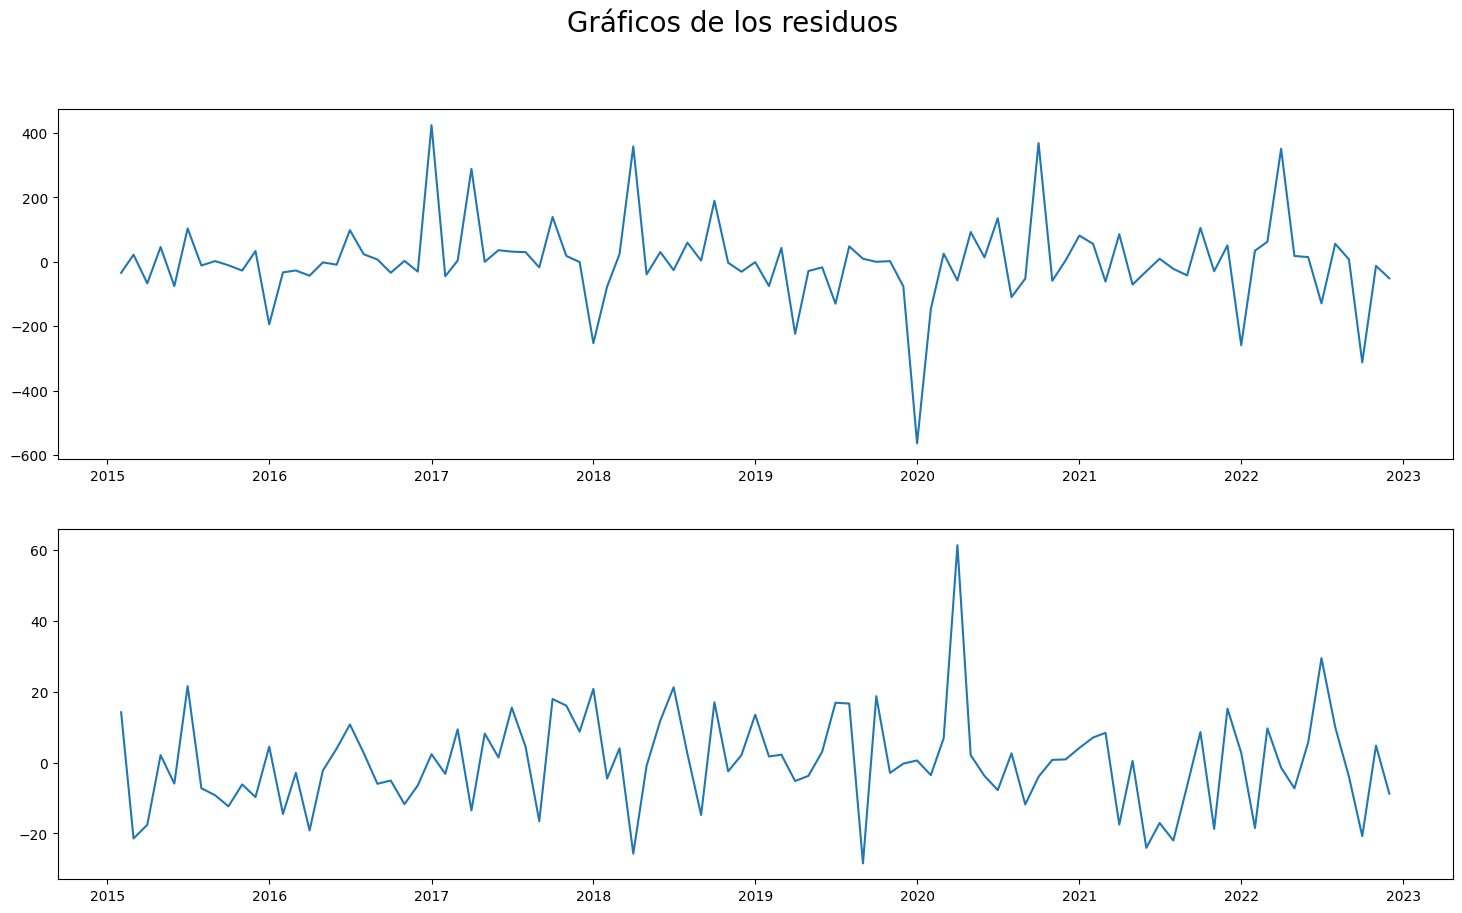

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Graficar la autocorrelación de los residuos del nuevo modelo
resid = res.resid
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(resid.iloc[:,i]) for i in range(2)]
plt.show()

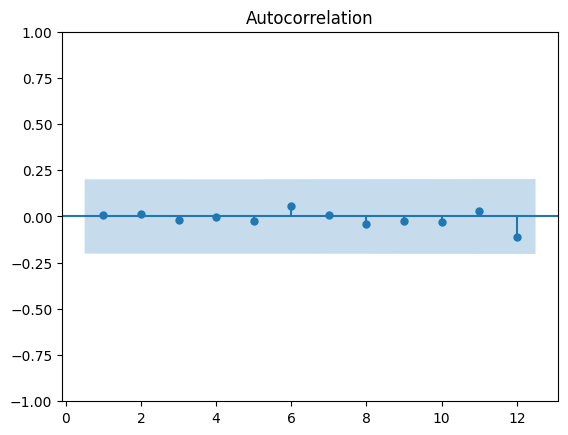

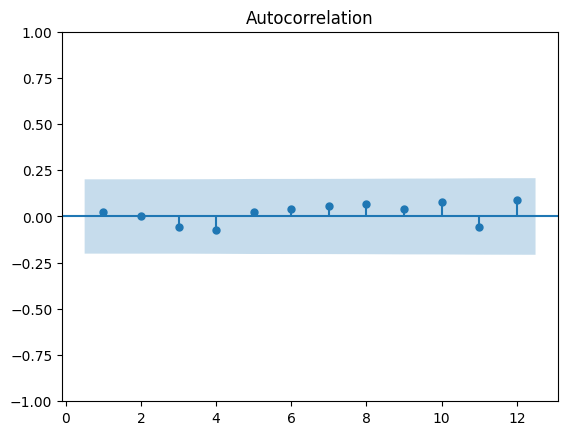

In [41]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(resid.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Se observa que casi todos los puntos están dentro del intervalo de confianza hasta el rezago 12, lo que sugiere que no hay autocorrelaciones significativas para esos rezagos. Esto es un buen indicio y sugiere que el modelo está adecuadamente especificado para estos rezagos.

#### Valores predichos


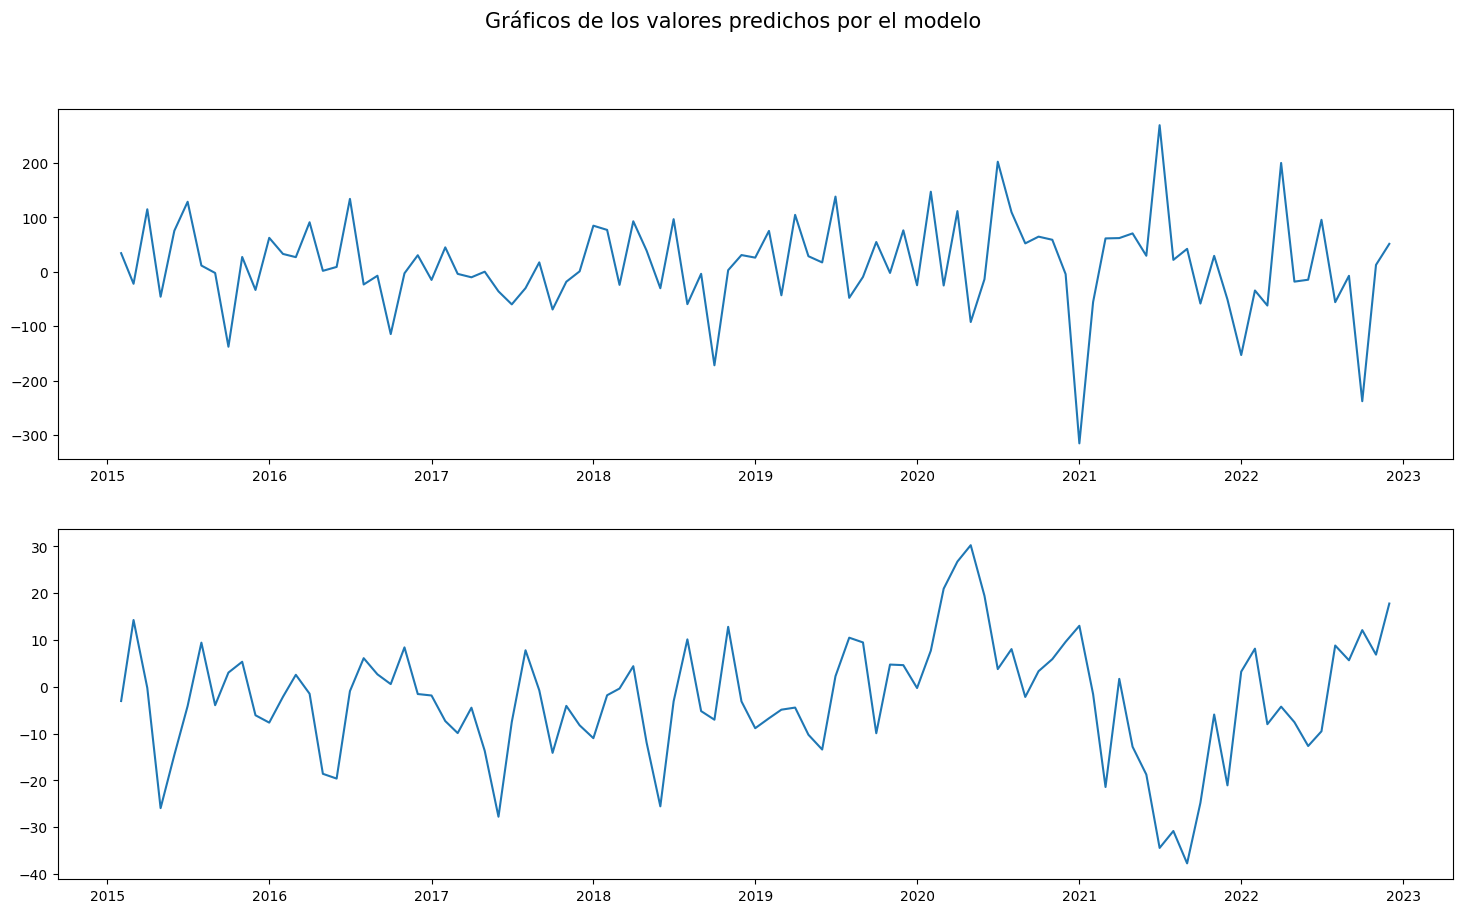

In [42]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.



In [43]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=9)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

Orden del modelo: 12
Predicciones:


,Compraventa_Unitario_pred,ParadosReg_pred
Fecha,,
2023-01-01,201.910355,2.379899
2023-02-01,-8.083212,-20.290327
2023-03-01,80.843013,-4.563862
2023-04-01,175.210822,-8.491472
2023-05-01,61.067598,-7.779872
2023-06-01,4.391445,-13.332569
2023-07-01,-105.858395,7.106044
2023-08-01,5.580167,20.140429
2023-09-01,-52.024490,18.016682


<Figure size 1200x1000 with 0 Axes>

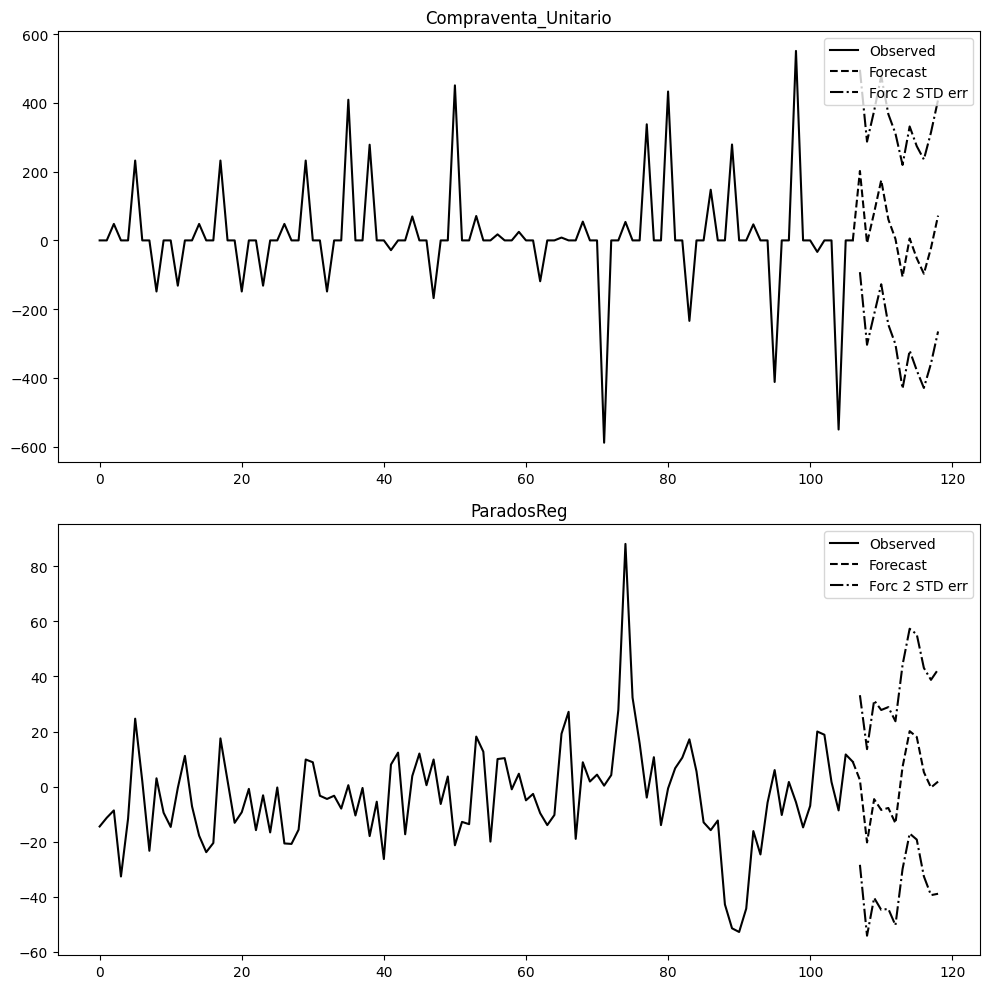

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


#### Invirtiendo la transformación de los pronósticos a la escala original


Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)



In [45]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [46]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=False)
output

,Compraventa_Unitario,ParadosReg
Fecha,,
2023-01-01,5631.893688,525.879899
2023-02-01,5623.810476,505.589571
2023-03-01,5704.653489,501.025710
2023-04-01,5879.864311,492.534238
2023-05-01,5940.931908,484.754367
2023-06-01,5945.323353,471.421798
2023-07-01,5839.464959,478.527841
2023-08-01,5845.045125,498.668271
2023-09-01,5793.020636,516.684952


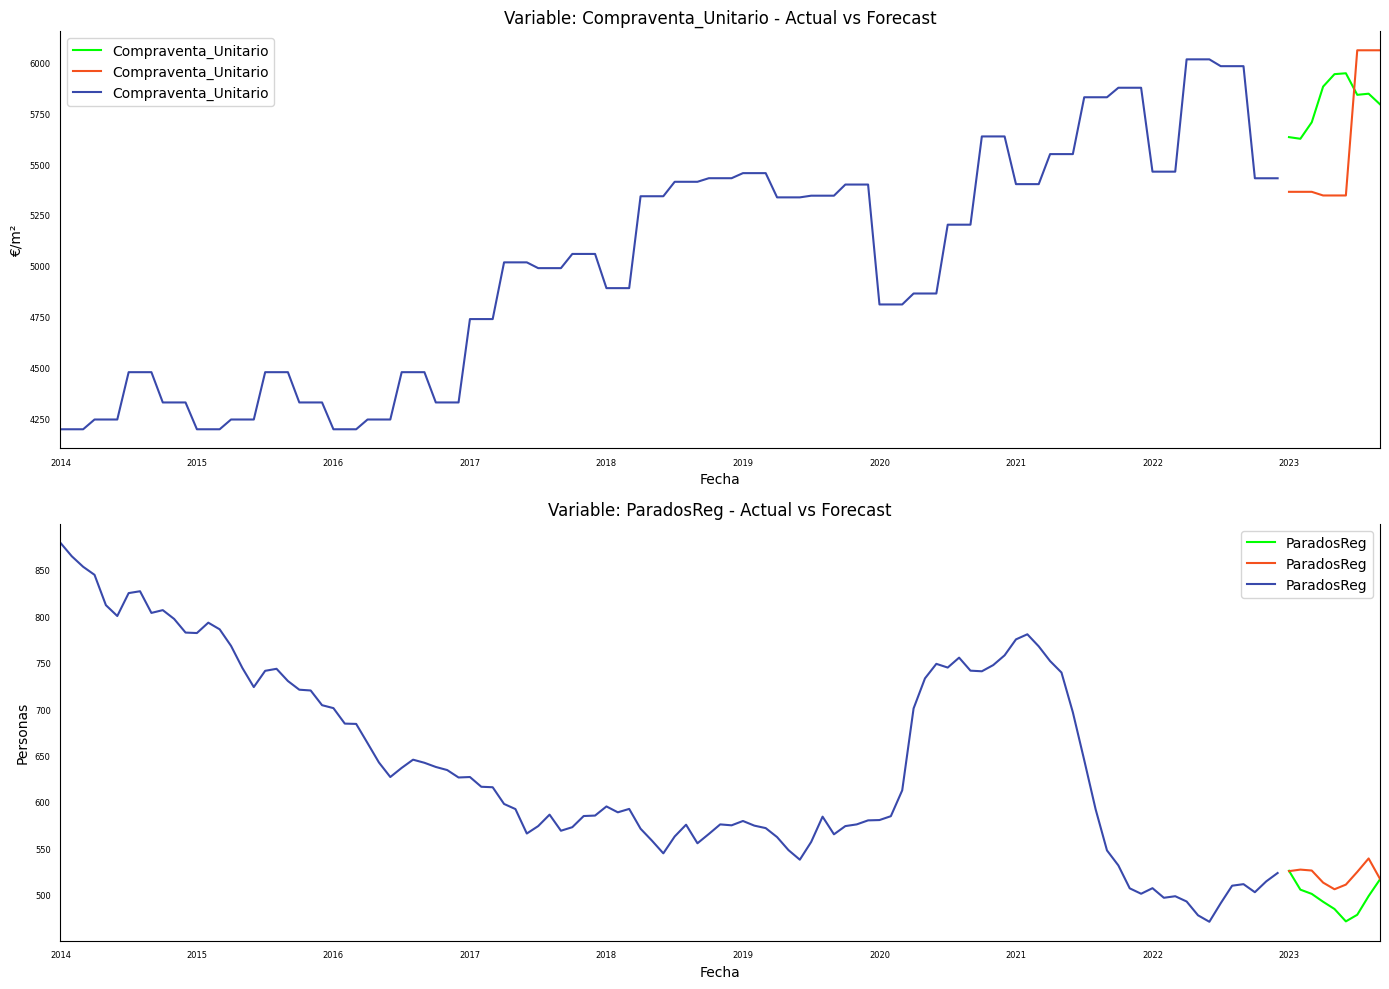

In [47]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', 'Personas']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    output[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [48]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [49]:
for i in ['Compraventa_Unitario','ParadosReg']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , output[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 157708.59922230328
MAE is : 366.23850067735253
RMSE is : 397.12542001526833
MAPE is : 6.674906976911223
R2 is : -0.43296610790609935

Evaluation metric for ParadosReg
Evaluation metric results:-
MSE is : 812.2705041642342
MAE is : 23.96368338847811
RMSE is : 28.5003597199094
MAPE is : 4.589602932583293
R2 is : -7.814242191346118



El modelo VAR para Compraventa_Unitario muestra un MSE de 157708.60, MAE de 366.24, RMSE de 397.13, MAPE de 6.67%, y un R2 negativo de -0.43, indicando un mal ajuste. Para ParadosReg, el MSE es 812.27, MAE 23.96, RMSE 28.50, MAPE 4.59%, y R2 de -7.81, también mostrando un mal rendimiento. Ambos modelos presentan errores significativos y ajustes muy pobres, sugiriendo la necesidad de explorar otras metodologías para mejorar las predicciones.

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, output)))

Mean absolute error: 195.10109203291532
Root mean squared error: 281.53229808182533


### Modelo VARMA (Auto Arima)

El modelo VARMA (Vector Autoregressive Moving Average) es una técnica estadística utilizada en análisis de series temporales que combina los modelos VAR (Vector Autoregressive) y MA (Moving Average). Es especialmente útil cuando se trata de series temporales múltiples, permitiendo modelar la interdependencia entre varias series a lo largo del tiempo junto con términos de error autocorrelacionados.

In [51]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.1 MB/s eta 0:00:00


#### Ajustando el modelo

#####Auto Arima

Aplicaremos autoarima, para determinar los valores de p, q y d

In [52]:
import pmdarima as pm

In [53]:

pq = []
for name in ['Compraventa_Unitario', 'ParadosReg']:
    print(f'Searching order of p and q for : {name}')
    # Ajusta un modelo ARIMA para cada columna
    stepwise_model = pm.auto_arima(X_train_transformed[name],
                                start_p=0, start_q=0,
                                max_p=4, max_q=4,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True,
                                maxiter=1000)
    # Obtiene los parámetros óptimos de p y q del modelo
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    # Agrega los parámetros óptimos a la lista pq
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Compraventa_Unitario
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1375.770, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1377.770, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1377.770, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1379.770, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1377.125, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.626 seconds
optimal order for:Compraventa_Unitario is: (0, 0, 0) 


Searching order of p and q for : ParadosReg
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=927.789, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=899.585, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=904.542, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=901.584, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=901.583, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0]     

In [54]:
pq

[(0, 0, 0), (1, 0, 0)]

- **Compraventa_Unitario:** Este resultado indica que un modelo de "ruido blanco" es el más adecuado para esta serie, ya que un ARIMA(0,0,0) significa que no hay dependencia autoregresiva ni de promedios móviles. Esencialmente, no se detecta un patrón temporal significativo en los datos bajo el criterio de información de Akaike (AIC).

- **ParadosReg:** el modelo ARIMA(1,0,0) indica que la serie es mejor modelada considerando una dependencia autoregresiva de primer orden. Esto implica que los valores futuros dependen linealmente del valor inmediatamente anterior, un indicativo de cierta persistencia o inercia en la serie temporal.

#####Seleccion del modelo

In [55]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [56]:
model = VARMAX(X_train_transformed[['Compraventa_Unitario','ParadosReg']], order=(1,0),trend='n').fit(disp=False)

In [57]:
model.summary()

Dep. Variable:,"['Compraventa_Unitario', 'ParadosReg']",No. Observations:,107
Model:,VAR(1),Log Likelihood,-1133.939
Date:,"Thu, 16 May 2024",AIC,2281.877
Time:,17:03:18,BIC,2300.587
Sample:,02-01-2014,HQIC,2289.462
,- 12-01-2022,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.01, 0.04",Jarque-Bera (JB):,"173.87, 82.83"
Prob(Q):,"0.94, 0.84",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"3.63, 1.94",Skew:,"-0.06, 0.99"
Prob(H) (two-sided):,"0.00, 0.05",Kurtosis:,"9.24, 6.83"


El modelo VAR(1) no muestra una relación significativa entre Compraventa_Unitario y ParadosReg en ninguno de los coeficientes, excepto por la relación autoregresiva de ParadosReg. Las pruebas de Jarque-Bera y heterocedasticidad indican problemas de normalidad y varianza no constante, respectivamente. Esto sugiere que el modelo puede no ser el más adecuado para estos datos y podría ser necesario considerar otros modelos o transformaciones de datos.

#### Valores predichos


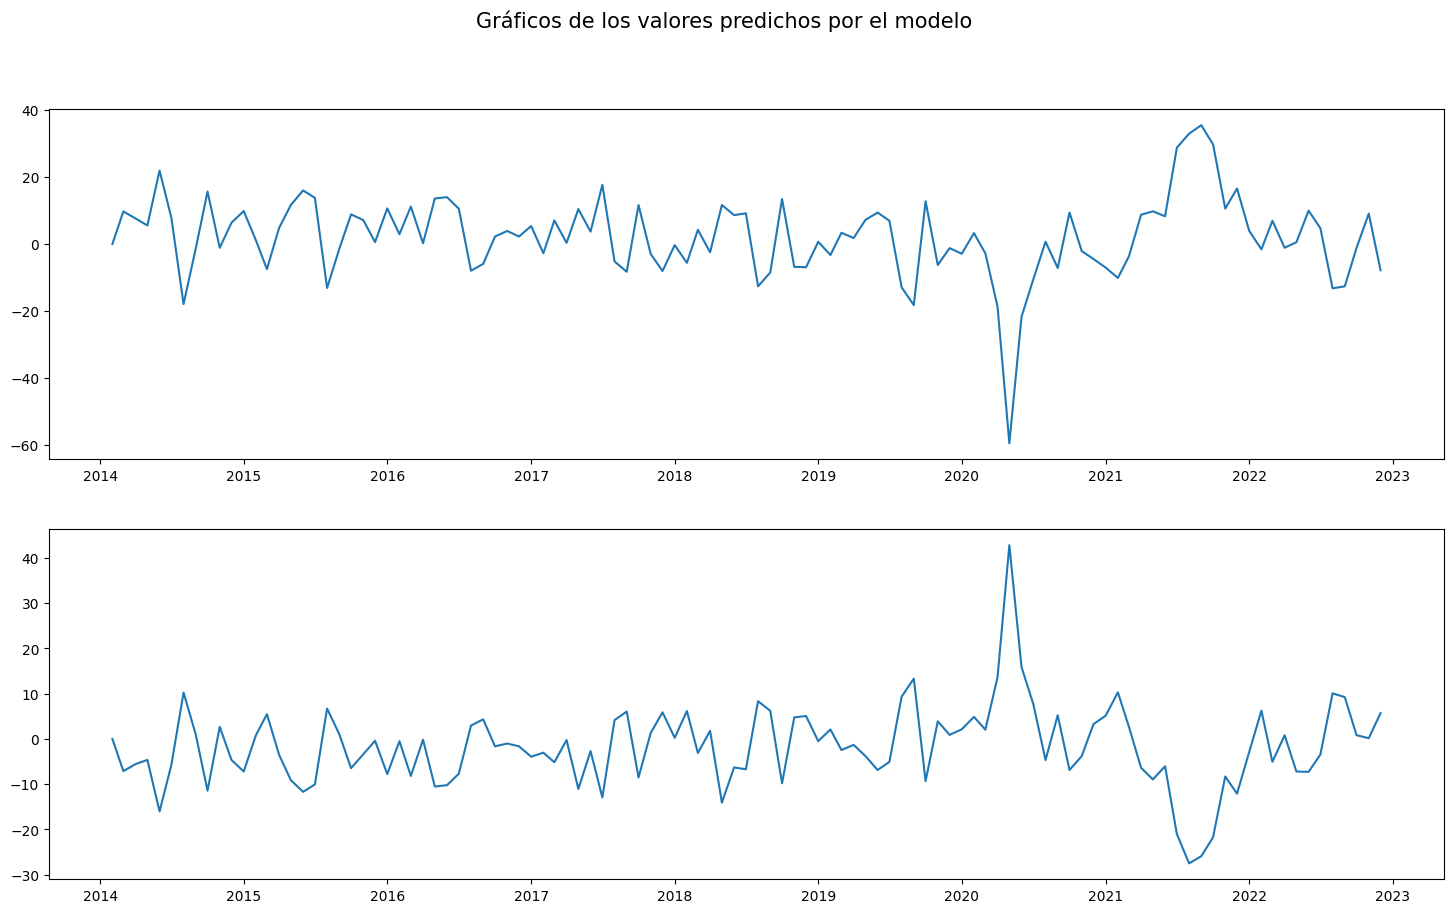

In [58]:
y_fitted = model.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


In [59]:
result = model.forecast(steps = 9)

In [60]:
result

,Compraventa_Unitario,ParadosReg
2023-01-01,-6.040362,4.415705
2023-02-01,-2.927873,2.214956
2023-03-01,-1.469250,1.110222
2023-04-01,-0.736435,0.556500
2023-05-01,-0.369139,0.278946
2023-06-01,-0.185031,0.139822
2023-07-01,-0.092747,0.070086
2023-08-01,-0.046490,0.035131
2023-09-01,-0.023303,0.017609


#### Invertiendo la transformacion de los pronosticos a la escala original

In [61]:
def inverse_diff(actual_df, pred_df, second_diff=False):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        if second_diff:
          df_res[str(col)] = (actual_df[col].iloc[-1]- actual_df[col].iloc[-2]) + df_res[str(col)].cumsum()

        df_res[str(col)] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [62]:
res = inverse_diff(df_paroBarna[['Compraventa_Unitario', 'ParadosReg']],result,False)

In [63]:
res

,Compraventa_Unitario,ParadosReg
2023-01-01,6052.042972,521.582372
2023-02-01,6049.115099,523.797328
2023-03-01,6047.645849,524.907550
2023-04-01,6046.909413,525.464051
2023-05-01,6046.540274,525.742997
2023-06-01,6046.355242,525.882819
2023-07-01,6046.262495,525.952905
2023-08-01,6046.216006,525.988036
2023-09-01,6046.192703,526.005645


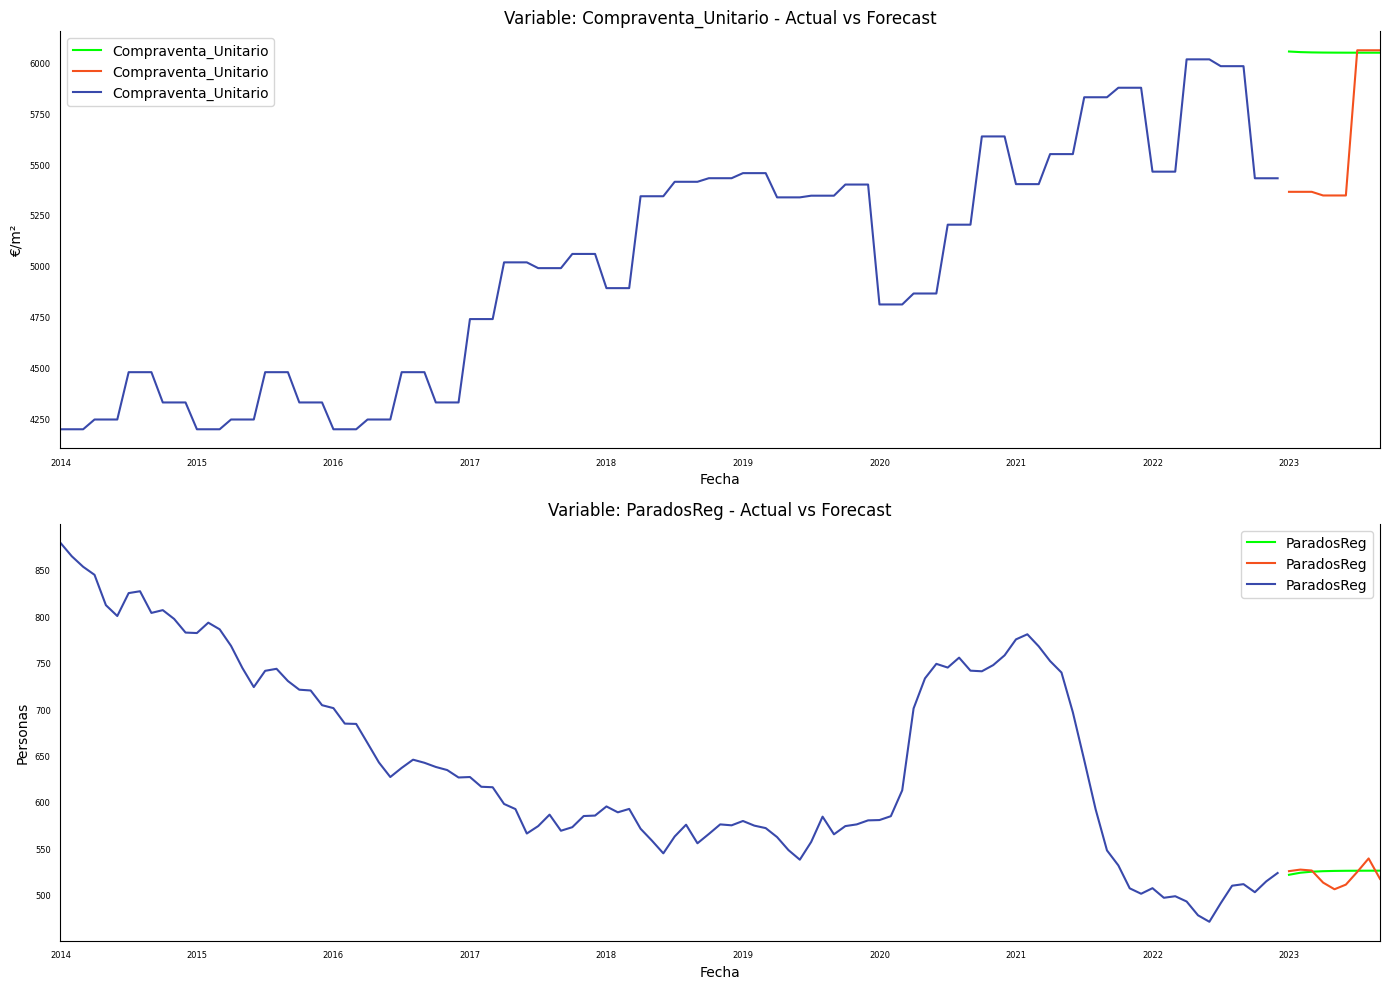

In [64]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', 'Personas']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    res[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo

In [65]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [66]:
for i in ['Compraventa_Unitario','ParadosReg']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , res[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 320799.3982283799
MAE is : 466.3486271968698
RMSE is : 566.391559107637
MAPE is : 8.70106261649242
R2 is : -1.9148357626965087

Evaluation metric for ParadosReg
Evaluation metric results:-
MSE is : 116.02819741664149
MAE is : 8.752570082240368
RMSE is : 10.771638566933143
MAPE is : 1.692568216470279
R2 is : -0.25906410218339837



Las métricas de evaluación para Compraventa_Unitario y ParadosReg indican un mal rendimiento de los modelos. Compraventa_Unitario tiene un MSE de 320799.40, MAE de 466.35, RMSE de 566.39, MAPE de 8.70%, y R² de -1.91. ParadosReg presenta un MSE de 116.03, MAE de 8.75, RMSE de 10.77, MAPE de 1.69%, y R² de -0.26. Los valores negativos de R² sugieren que los modelos no capturan adecuadamente la variación en los datos, necesitando ajustes.

In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, res))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, res)))

Mean absolute error: 237.5505986395551
Root mean squared error: 400.57173291796096


##Conclusiones

El análisis realizado demuestra que la modelización de series temporales complejas como "Compraventa_Unitario" y "ParadosReg" requiere un enfoque detallado y específico. A través de la aplicación de varios modelos (VAR y VARMA), se ha evaluado su capacidad predictiva. A continuación, se presentan las conclusiones clave del análisis:

1. Cointegración y Estacionariedad: Las pruebas iniciales de cointegración
indicaron que "Compraventa_Unitario" y "ParadosReg" no tienen una relación de equilibrio a largo plazo. La estacionariedad de las series se logró mediante la diferenciación, lo que es crucial para la correcta aplicación de los modelos VAR y VARMA.

2. Modelos VAR: Se aplicó un modelo VAR(1) inicialmente, seleccionando el orden óptimo mediante criterios AIC, BIC y HQIC. Los resultados mostraron que las dos series no tienen una relación causal significativa según las pruebas de causalidad de Granger. Los residuos del modelo mostraron ser estacionarios y sin autocorrelación significativa, pero los pronósticos resultaron en errores elevados y un mal ajuste (R² negativo).

3. Modelos VARMA: El modelo VARMA fue ajustado utilizando Auto ARIMA para determinar los valores óptimos de p, q y d. Los resultados indicaron que "Compraventa_Unitario" se comporta como un "ruido blanco", mientras que "ParadosReg" sigue un patrón AR(1). Aunque los pronósticos a futuro fueron ligeramente mejores que los del modelo VAR, las métricas de evaluación aún indicaron un ajuste deficiente.

4. Evaluación de Modelos: Las métricas de evaluación para ambos modelos (MSE, MAE, RMSE, MAPE y R²) mostraron que los modelos tienen un rendimiento pobre. Los valores negativos de R² sugieren que los modelos no capturan adecuadamente la variación en los datos y subrayan la necesidad de explorar modelos adicionales o transformaciones de datos.

5. Limitaciones y Consideraciones Futuras: Los resultados obtenidos indican la necesidad de considerar otras metodologías, como modelos más avanzados de machine learning o técnicas de modelado híbrido. Además, se sugiere una revisión más detallada de posibles factores exógenos que podrían influir en las series temporales analizadas.

En resumen, aunque se ha avanzado en la comprensión de las relaciones entre "Compraventa_Unitario" y "ParadosReg", los modelos utilizados no lograron proporcionar pronósticos precisos. Es esencial seguir explorando enfoques alternativos y ajustar los modelos para mejorar su rendimiento predictivo en futuros análisis.

